In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
%load_ext autoreload
%autoreload 2

import pickle
import time
import tensorflow as tf
import numpy as np

from analysis import *
from spectral_adversarial_regularization.models import elunet as model

%matplotlib inline

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Xtr = mnist.train.images.reshape(-1, 28, 28, 1)
Ytr = mnist.train.labels.astype(float)

Xtt = mnist.test.images.reshape(-1, 28, 28, 1)
Ytt = mnist.test.labels.astype(float)

np.random.seed(0)
Ytr_rand = np.random.choice(range(10), np.shape(Ytr)).astype(float)
Ytt_rand = np.random.choice(range(10), np.shape(Ytt)).astype(float)

val_set = {'X': Xtt[:500], 'Y': Ytt[:500]}
C2 = np.mean([np.sqrt(np.sum(np.square(i))) for i in Xtr])
gamma = 0.04*C2
eps_wrm = 1./(2*gamma)

eps_wrm = 1.3 # Note the above eps_wrm is 1.3563756028, but we'll use 1.3 as used in the paper's code

eps_list = np.linspace(0, 0.25, 9)*C2
methods = ['erm', 'fgm', 'pgm', 'wrm']

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
arch = model.elunet
save_dir = os.path.join('save_weights', 'mnist', 'wrm')
train_network(Xtr, Ytr, val_set, arch, save_dir, eps=eps_wrm, adv='wrm', retrain=False)

Model already exists.. loading trained model..
INFO:tensorflow:Restoring parameters from save_weights/mnist/wrm/checkpoints/epoch200
Train acc: 1.00 (10.2 s elapsed)


In [8]:
# Estimate eps for the other samples using the perturbation achieved for each test sample
save_dir = os.path.join('save_weights', 'mnist', 'wrm')
arch = model.elunet

Xtr_adv_wrm = ad.build_graph_and_gen_adv_examples(Xtr, arch, save_dir, beta=1, num_channels=1,
                                                  load_epoch=25, method=ad.wrm, eps=eps_wrm)
    
eps = np.sqrt(np.mean([np.sum(np.square(i)) for i in Xtr_adv_wrm-Xtr])) 
print(eps/C2)

# Note: the above eps/C2 is 0.0558342058, but we'll use 0.05 as seen in Figure 2a of the paper
eps = 0.05*C2

INFO:tensorflow:Restoring parameters from save_weights/mnist/wrm/checkpoints/epoch25
0.0558342058134


In [6]:
arch = model.elunet
for method in ['erm', 'fgm', 'pgm']:
    save_dir = os.path.join('save_weights', 'mnist', method)
    train_network(Xtr, Ytr, val_set, arch, save_dir, eps=eps, adv=method, retrain=False)

Model already exists.. loading trained model..
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm/checkpoints/epoch88
Train acc: 1.00 (3.1 s elapsed)
Model already exists.. loading trained model..
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/fgm/checkpoints/epoch108
Train acc: 1.00 (3.2 s elapsed)
Model already exists.. loading trained model..
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/pgm/checkpoints/epoch35
Train acc: 1.00 (3.1 s elapsed)


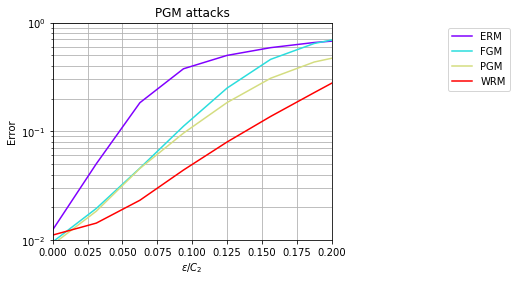

In [13]:
# Evaluate robustness of networks
methods = ['erm', 'fgm', 'pgm', 'wrm']
curves_file = 'save_weights/mnist/adv_attack_curves.pickle'

if os.path.isfile(curves_file):
    adv_results = pickle.load(file(curves_file, 'rb'))
else:
    adv_results = {}
    for method in methods:
        save_dir = os.path.join('save_weights_final', 'mnist', method)
        s_norm = dl_utils.get_overall_sn(save_dir, arch, num_channels=1, load_epoch=25)
        acc, adv_accs = get_adv_acc_curve(Xtt, Ytt, save_dir, arch, eps_list, load_epoch=25)
        adv_results[method] = (acc, adv_accs, s_norm)
    pickle.dump(adv_results, file(curves_file, 'wb'))
        
plot_acc_curves(adv_results, eps_list/C2, diff_methods=True, report_test=False,
                savename='Figures/mnist_adv_attack_curves')

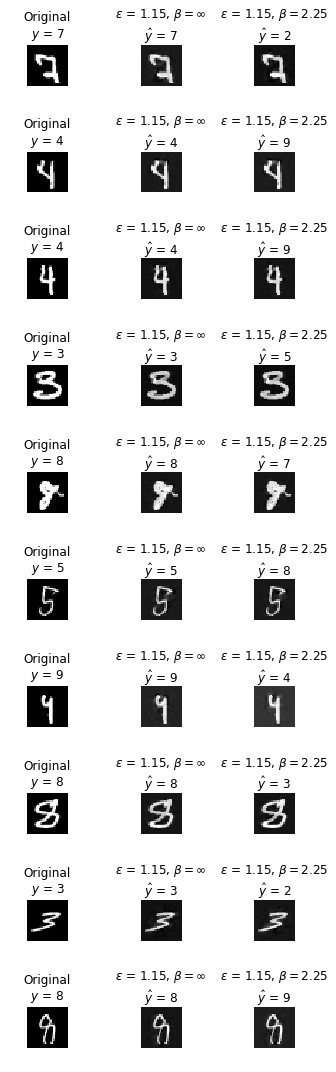

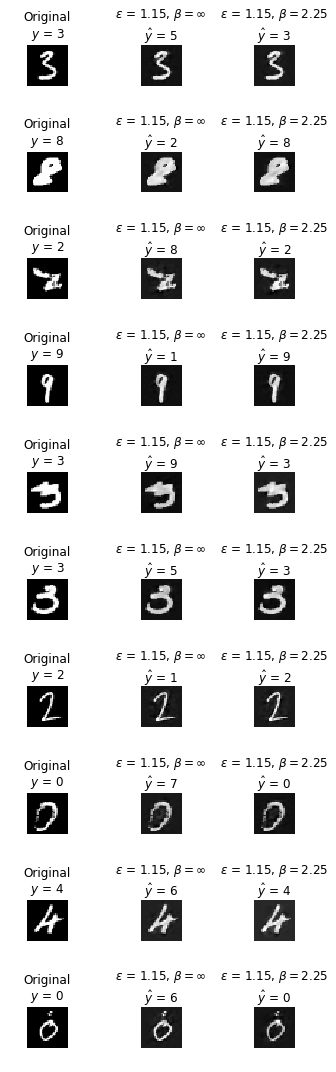

In [62]:
eps = 0.125*C2
beta = 2.25
label_dict = {i:i for i in range(10)}
save_dir = 'save_weights/mnist/wrm/'
save_dir_sn = 'save_weights/mnist/wrm_beta%s'%(beta)

# Training samples
# Xtr_adv, Ytr_adv, Xtr_adv_sn, Ytr_adv_sn = perturb_images_wrm_v_wrmsn(Xtr, Ytr, eps, beta,
#                                                                       model.elunet, model.elunet_sn,
#                                                                       save_dir, save_dir_sn,
#                                                                       preprocess=False, load_epoch=25)
inds_of_interest = np.where((Ytr != Ytr_adv_sn) & (Ytr == Ytr_adv))[0]
show_perturbed_images(Xtr.reshape(-1, 28, 28), Xtr_adv.reshape(-1, 28, 28), Xtr_adv_sn.reshape(-1, 28, 28),
                      Ytr, Ytr_adv, Ytr_adv_sn, label_dict, eps, beta,
                      n=10, seed=0, savename='Figures/mnist_pgm_attacks_sn_v_nosn_train.pdf',
                      inds_of_interest=inds_of_interest)

# Test samples
# Xtt_adv, Ytt_adv, Xtt_adv_sn, Ytt_adv_sn = perturb_images_wrm_v_wrmsn(Xtt, Ytt, eps, beta,
#                                                                       model.elunet, model.elunet_sn,
#                                                                       save_dir, save_dir_sn,
#                                                                       preprocess=False, load_epoch=25)
inds_of_interest = np.where((Ytt != Ytt_adv) & (Ytt == Ytt_adv_sn))[0]
show_perturbed_images(Xtt.reshape(-1, 28, 28), Xtt_adv.reshape(-1, 28, 28), Xtt_adv_sn.reshape(-1, 28, 28),
                      Ytt, Ytt_adv, Ytt_adv_sn, label_dict, eps, beta,
                      n=10, seed=0, savename='Figures/mnist_pgm_attacks_sn_v_nosn_test.pdf',
                      inds_of_interest=inds_of_interest)

# Testing spectral normalization

### Comparing all methods

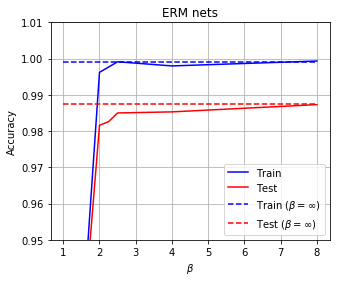

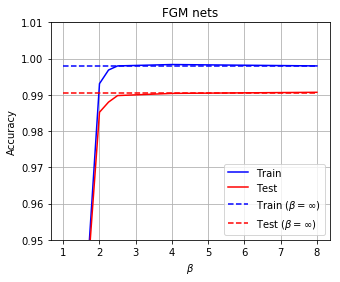

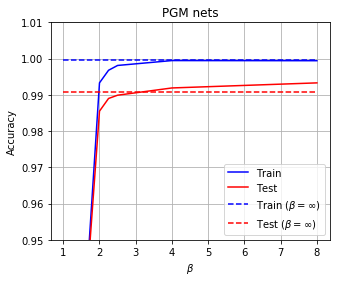

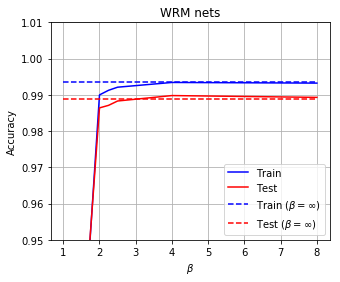

In [23]:
# Get final training and test accuracies
for method in methods:
    train_test_accs_file = 'save_weights/mnist/%s_train_test_accs.pickle'%(method)
    results = get_train_test_accs(Xtr, Ytr, Xtt, Ytt, model.elunet_sn, model.elunet, adv=method,
                                  load_epoch=25, train_test_accs_file=train_test_accs_file)
    plot_train_test_accs(results, savename='Figures/mnist_train_test_accs_%s'%(method), logy=False,
                         title='%s nets'%(method.upper()), ylim=(0.95, 1.01), logx=False)
    df = train_test_accs_to_pd_table(results).round(3)
#     print(df.to_latex(index=False).replace('\$\\textbackslashbeta\\$', '$\\beta$'))
#     display(df)

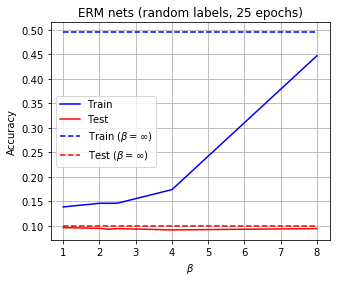

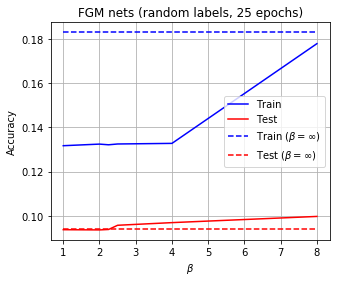

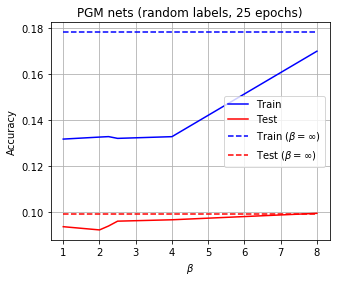

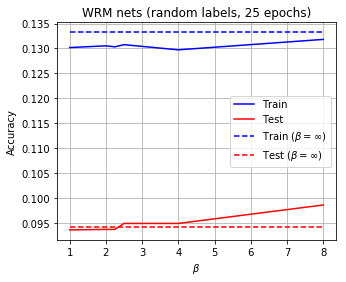

In [27]:
# Get final training and test accuracies for networks trained on random labels
for method in methods:
    train_test_accs_file = 'save_weights/mnist/%s_train_test_accs_randlabels.pickle'%(method)
    results = get_train_test_accs(Xtr, Ytr_rand, Xtt, Ytt_rand, model.elunet_sn, model.elunet,
                                  adv=method, load_epoch=25, train_test_accs_file=train_test_accs_file,
                                  randmode=True)
    plot_train_test_accs(results, savename='Figures/mnist_train_test_accs_randlabels_%s'%(method),
                         logy=False, title='%s nets (random labels, 25 epochs)'%(method.upper()),
                         ylim=None, logx=False)

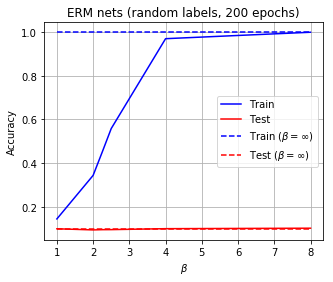

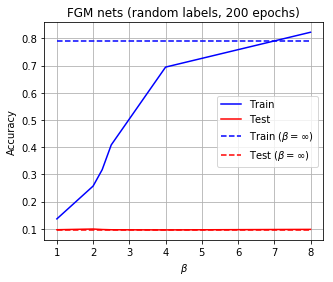

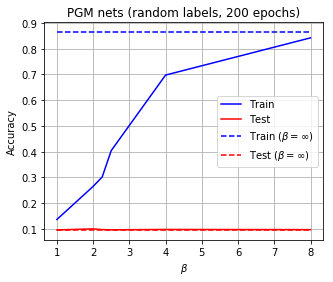

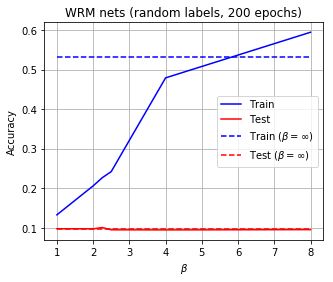

In [28]:
# Get final training and test accuracies for networks trained on random labels
for method in methods:
    train_test_accs_file = 'save_weights/mnist/%s_train_test_accs_randlabels_loadepoch200.pickle'%(method)
    results = get_train_test_accs(Xtr, Ytr_rand, Xtt, Ytt_rand, model.elunet_sn, model.elunet,
                                  adv=method, load_epoch=200, train_test_accs_file=train_test_accs_file,
                                  randmode=True)
    plot_train_test_accs(results, savename='Figures/mnist_train_test_accs_randlabels_loadepoch200_%s'%(method), 
                         logy=False, title='%s nets (random labels, 200 epochs)'%(method.upper()),
                         ylim=None, logx=False)

In [31]:
# Estimates of final spectral norms
for method in methods:
    snorms_file = 'save_weights/mnist/%s_final_sn.pickle'%(method)
    results = get_final_sn(method, model.elunet_sn, model.elunet, load_epoch=25, snorms_file=snorms_file)
    df = snorms_to_pd_table(results).round(2)
#     print(df.to_latex(index=False).replace('\$\\textbackslashbeta\\$', '$\\beta$'))
    display(df) 

,layers,$\beta = \infty$,$\beta$ = 1.0,$\beta$ = 2.0,$\beta$ = 2.25,$\beta$ = 2.5,$\beta$ = 4.0,$\beta$ = 8.0
0,conv1,4.02,1.01,2.05,2.42,2.56,4.02,6.37
1,conv2,18.13,1.04,2.06,2.27,2.50,3.96,7.97
2,conv3,11.24,0.98,2.08,2.34,2.55,3.99,8.00
3,fc,1.74,1.00,2.02,2.28,2.49,2.24,1.81


,layers,$\beta = \infty$,$\beta$ = 1.0,$\beta$ = 2.0,$\beta$ = 2.25,$\beta$ = 2.5,$\beta$ = 4.0,$\beta$ = 8.0
0,conv1,2.95,1.00,2.00,2.24,2.57,3.98,5.06
1,conv2,28.63,1.05,2.03,2.25,2.52,4.02,8.00
2,conv3,8.91,1.08,2.11,2.30,2.51,4.00,8.00
3,fc,1.71,1.04,2.01,2.30,2.50,2.87,2.41


,layers,$\beta = \infty$,$\beta$ = 1.0,$\beta$ = 2.0,$\beta$ = 2.25,$\beta$ = 2.5,$\beta$ = 4.0,$\beta$ = 8.0
0,conv1,4.42,1.02,2.10,2.39,2.61,4.02,5.39
1,conv2,23.40,1.07,2.06,2.24,2.53,4.02,7.83
2,conv3,9.24,1.04,2.06,2.28,2.56,4.06,8.00
3,fc,1.58,1.02,1.98,2.26,2.49,2.13,1.62


,layers,$\beta = \infty$,$\beta$ = 1.0,$\beta$ = 2.0,$\beta$ = 2.25,$\beta$ = 2.5,$\beta$ = 4.0,$\beta$ = 8.0
0,conv1,2.11,1.01,2.02,2.26,2.50,3.99,3.01
1,conv2,11.20,1.00,2.02,2.25,2.49,4.01,8.00
2,conv3,4.69,1.01,1.98,2.26,2.50,4.00,4.96
3,fc,1.41,1.02,1.96,2.06,1.82,1.47,1.40


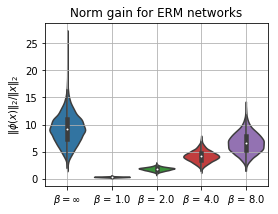

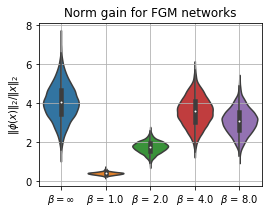

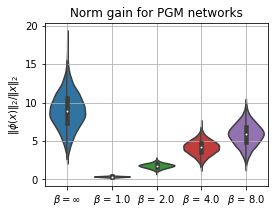

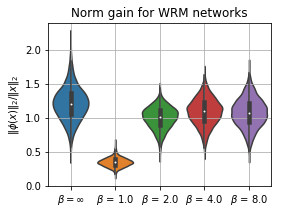

In [10]:
# Norm ratio of output layer to input
for method in methods:
    fcnorms_file = 'save_weights/mnist/%s_output_norms.pickle'%(method)
    norm_input = np.array([np.sqrt(np.sum(np.square(i))) for i in Xtt])
    results = get_output_norms(Xtt, method, model.elunet_sn, model.elunet, load_epoch=25, fcnorms_file=fcnorms_file)
    
    for k in results.keys():
        if '2.25' in k or '2.5' in k:
            results.pop(k)
    
    violin_plots_of_norm_output_to_input_ratios(results, norm_input, 
                                                title='Norm gain for %s networks'%(method.upper()),
                                                savename='Figures/mnist_violin_%s'%(method))

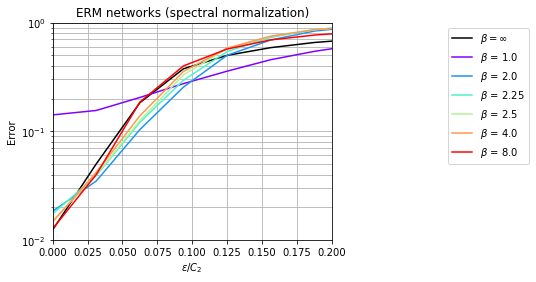

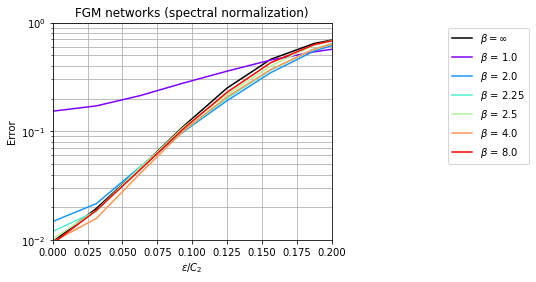

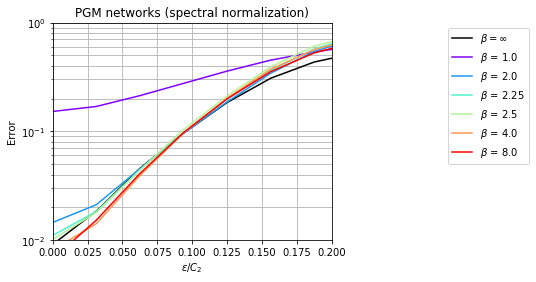

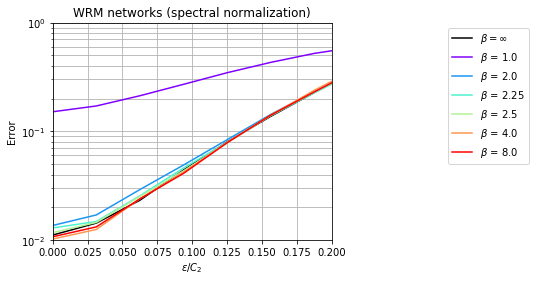

In [18]:
curves_file = 'save_weights/mnist/beta_adv_sweep_curves.pickle'

if os.path.isfile(curves_file):
    all_beta_curves = pickle.load(file(curves_file, 'rb'))
else:
    all_beta_curves = {}
    
for method in methods:
    if method not in all_beta_curves:
        all_beta_curves[method] = param_sweep_curves(Xtt, Ytt, method, eps_list, model.elunet_sn,
                                                     model.elunet, load_epoch=25)
        
    plot_acc_curves(all_beta_curves[method], eps_list/C2, report_test=False,
                    title='%s networks (spectral normalization)'%(method.upper()), sort_func=sort_func,
                    savename='Figures/mnist_adv_curves_%s'%(method))
    
# pickle.dump(all_beta_curves, file(curves_file, 'wb'))

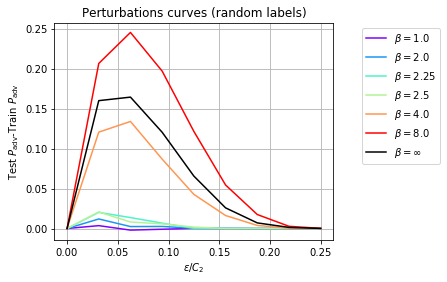

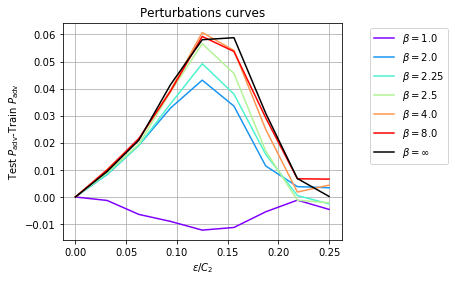

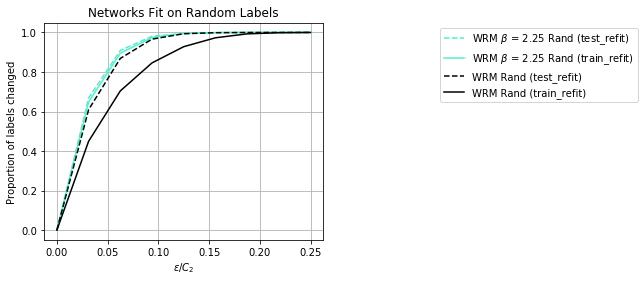

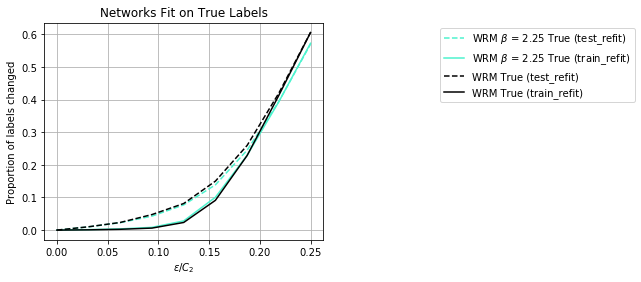

In [32]:
# Seeing how easily perturbed the network is on train v test data

# # Using true labels
# adv = 'wrm'
# curves_file = 'save_weights/mnist/%s_perturbation_curves_truelabels.pickle'%(adv)
# betas_of_interest = [0, 2.25]
# adv_results = get_train_v_test_adv_acc_curves(Xtr, Ytr, Xtt, Ytt, model.elunet_sn, model.elunet,
#                                               adv, eps_list, load_epoch=25, curves_file=curves_file,
#                                               betas_of_interest=betas_of_interest)
# plot_perturbation_curves(eps_list, adv_results)

adv = 'wrm'
curves_file = 'save_weights/mnist/%s_perturbation_curves.pickle'%(adv)
adv_results = get_perturbation_curves(Xtr, Xtt, model.elunet_sn, model.elunet, adv,
                                      eps_list, load_epoch=25, curves_file=curves_file, 
                                      maindir='save_weights/mnist/', verbose=False)

plot_perturbation_curves(eps_list/C2, adv_results, ylim=None,
                         title='Perturbations curves',
                         savename='Figures/mnist_perturbation_curves_%s'%(adv))

beta_list = [0, 2.25]
plot_perturbation_curves(eps_list/C2, adv_results, mode=2, betas_of_interest=beta_list)

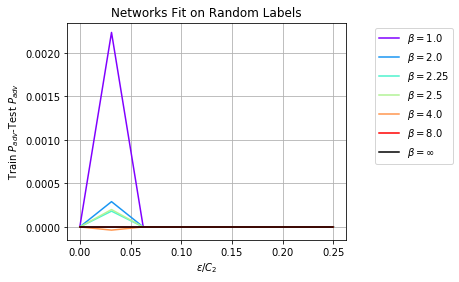

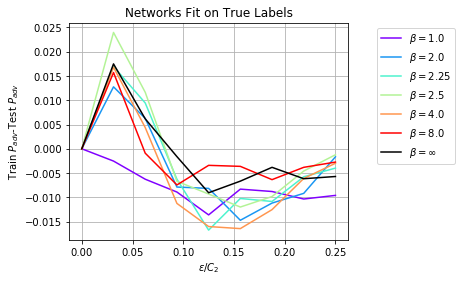

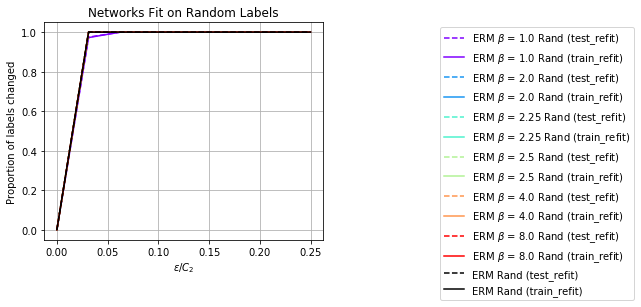

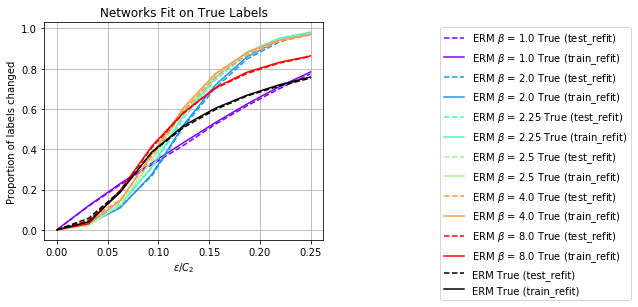

In [60]:
adv = 'erm'
curves_file = 'save_weights/mnist/%s_perturbation_curves.pickle'%(adv)
adv_results = get_perturbation_curves(Xtr, Xtt, model.elunet_sn, model.elunet, adv,
                                      eps_list, load_epoch=25, curves_file=curves_file, 
                                      maindir='save_weights/mnist/', verbose=False)

plot_perturbation_curves(eps_list/C2, adv_results, mode=1)
plot_perturbation_curves(eps_list/C2, adv_results, mode=2)

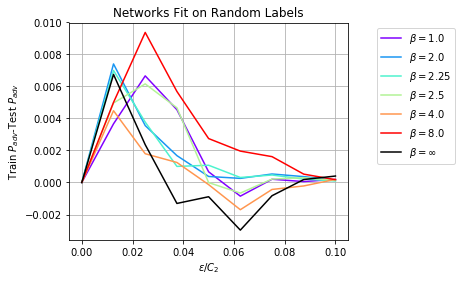

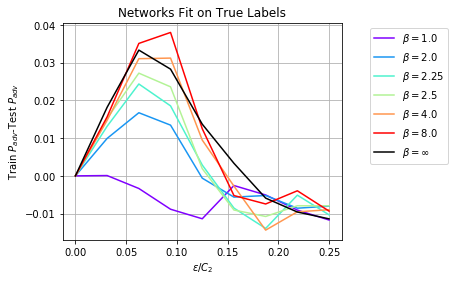

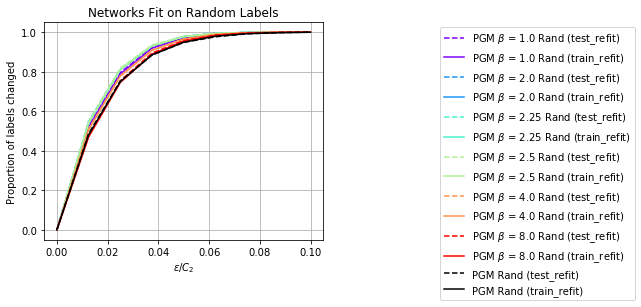

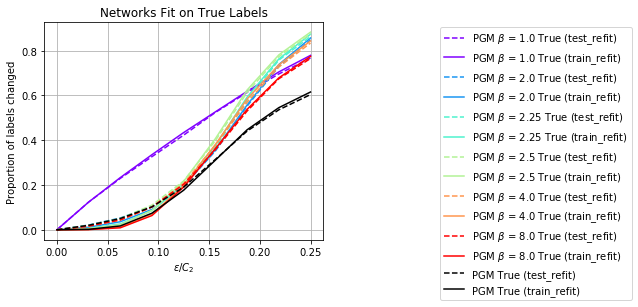

In [63]:
adv = 'pgm'
curves_file = 'save_weights/mnist/%s_perturbation_curves.pickle'%(adv)
eps_list_rand = np.linspace(0, 0.10, 9)*C2
adv_results = get_perturbation_curves(Xtr, Xtt, model.elunet_sn, model.elunet, adv,
                                      eps_list, load_epoch=25, curves_file=curves_file, 
                                      maindir='save_weights/mnist/', verbose=False,
                                      eps_list_rand=eps_list_rand)

plot_perturbation_curves(eps_list/C2, adv_results, eps_list_rand=eps_list_rand/C2)
#                         savename='Figures/perturbation_curves_%s'%(adv))

plot_perturbation_curves(eps_list/C2, adv_results, mode=2, eps_list_rand=eps_list_rand/C2)

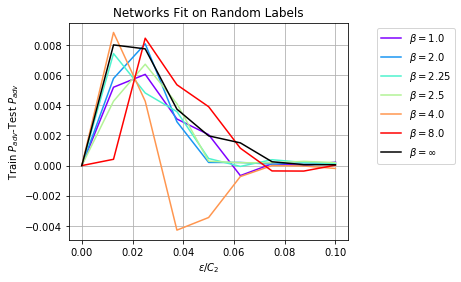

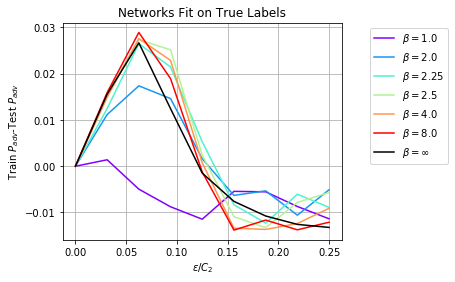

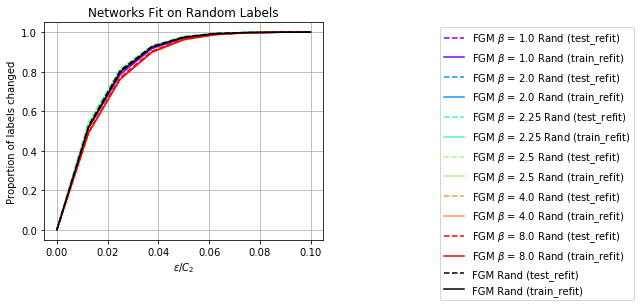

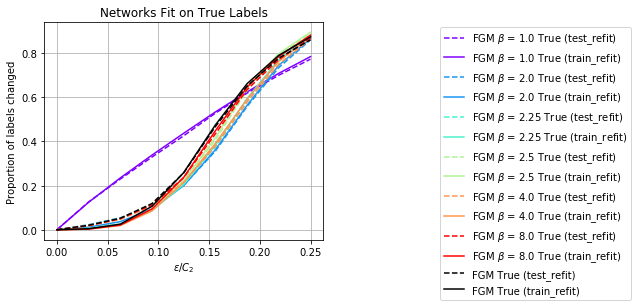

In [64]:
adv = 'fgm'
curves_file = 'save_weights/mnist/%s_perturbation_curves.pickle'%(adv)
eps_list_rand = np.linspace(0, 0.10, 9)*C2
adv_results = get_perturbation_curves(Xtr, Xtt, model.elunet_sn, model.elunet, adv,
                                      eps_list, load_epoch=25, curves_file=curves_file, 
                                      maindir='save_weights/mnist/', verbose=False,
                                      eps_list_rand=eps_list_rand)

plot_perturbation_curves(eps_list/C2, adv_results, eps_list_rand=eps_list_rand/C2)
#                         savename='Figures/perturbation_curves_%s'%(adv))

plot_perturbation_curves(eps_list/C2, adv_results, mode=2, eps_list_rand=eps_list_rand/C2)

### WRM

                 wrm with eps/C2 = 0.0558342060
         wrm_beta1.0 with eps/C2 = 0.0721508219
         wrm_beta2.0 with eps/C2 = 0.0612042067
        wrm_beta2.25 with eps/C2 = 0.0586298504
         wrm_beta2.5 with eps/C2 = 0.0574544632
         wrm_beta4.0 with eps/C2 = 0.0547897371
         wrm_beta8.0 with eps/C2 = 0.0539684452


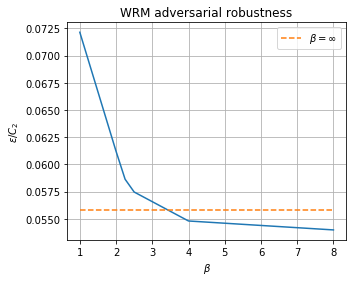

In [63]:
# Look at WRM robustness as a function of beta

eps_file = 'save_weights/mnist/wrm_eps_train.pickle'
results = get_eps_wrm(Xtr, model.elunet_sn, model.elunet, eps_wrm, load_epoch=25, eps_file=eps_file)

for k, v in sorted(results.items()):
    print('%20s with eps/C2 = %.10f'%(k, v/C2))
    
plot_wrm_robustness(results, C2=C2, savename='Figures/mnist_adv_robustness_with_SN', logx=False)

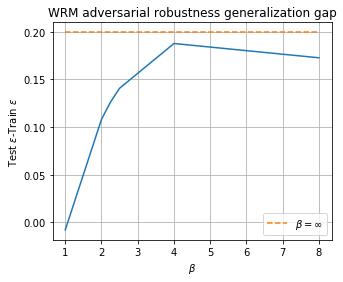

In [64]:
# Look at difference in robustness as a function of beta
eps_file = 'save_weights/mnist/wrm_eps_test.pickle'
results_tt = get_eps_wrm(Xtt, model.elunet_sn, model.elunet, eps_wrm, load_epoch=25, eps_file=eps_file)
results_diff = {k:results_tt[k]-results[k] for k in results}

plot_wrm_robustness(results_diff, C2=None, ylabel=u'Test $\epsilon$-Train $\epsilon$',
                    title='WRM adversarial robustness generalization gap',
                    savename='Figures/mnist_adv_robustness_generalization_with_SN', logx=False)

# Testing weight decay

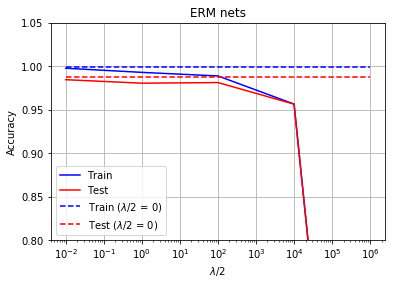

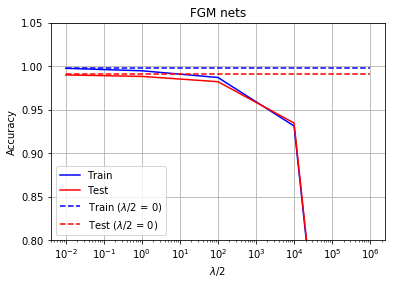

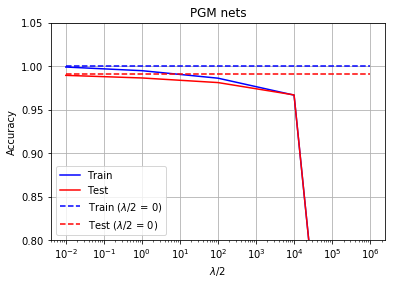

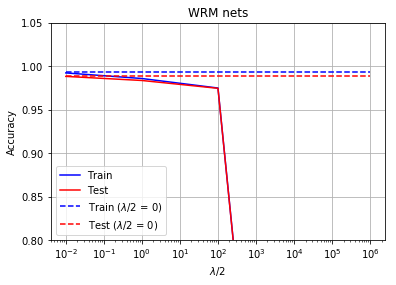

In [19]:
# Get final training and test accuracies
for method in methods:
    train_test_accs_file = 'save_weights/mnist/%s_train_test_accs_wd.pickle'%(method)
    results = get_train_test_accs(Xtr, Ytr, Xtt, Ytt, model.elunet_sn, model.elunet, adv=method,
                                  load_epoch=25, train_test_accs_file=train_test_accs_file, wdmode=True)
    
    # Grabbing no-regularization results
    results_ = pickle.load(file(train_test_accs_file.replace('_wd', ''), 'rb'))
    results[method] = results_[method]
    
    plot_train_test_accs(results, savename='Figures/mnist_train_test_accs_%s_wd'%(method), logy=False,
                         title='%s nets'%(method.upper()), wdmode=True, ylim=(0.8, 1.05))
#     df = train_test_accs_to_pd_table(results).round(3)

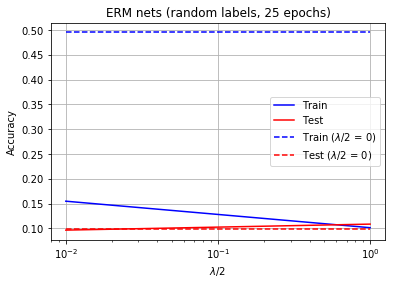

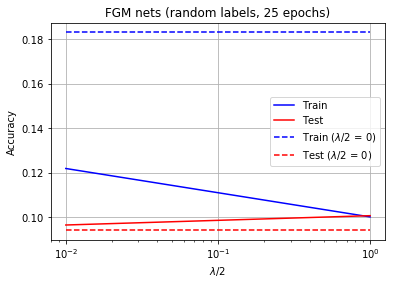

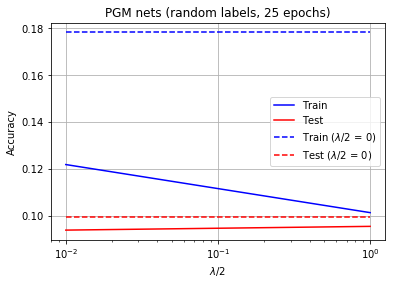

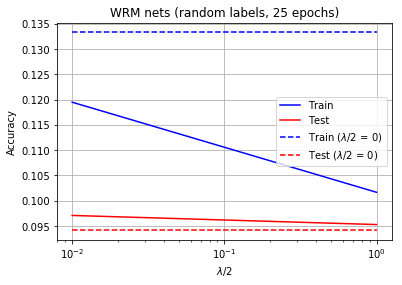

In [24]:
# Get final training and test accuracies for networks trained on random labels
for method in methods:
    train_test_accs_file = 'save_weights/mnist/%s_train_test_accs_wd_randlabels.pickle'%(method)
    results = get_train_test_accs(Xtr, Ytr_rand, Xtt, Ytt_rand, model.elunet_sn, model.elunet,
                                  adv=method, load_epoch=25, train_test_accs_file=train_test_accs_file,
                                  randmode=True, wdmode=True)
    
    # Grabbing no-regularization results
    results_ = pickle.load(file(train_test_accs_file.replace('_wd', ''), 'rb'))
    results[method+'_randlabels'] = results_[method+'_randlabels']
    
    plot_train_test_accs(results, savename='Figures/mnist_train_test_accs_randlabels_%s_wd'%(method),
                         logy=False, title='%s nets (random labels, 25 epochs)'%(method.upper()), wdmode=True)

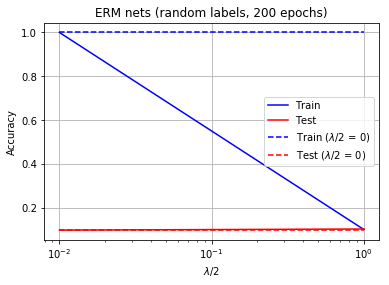

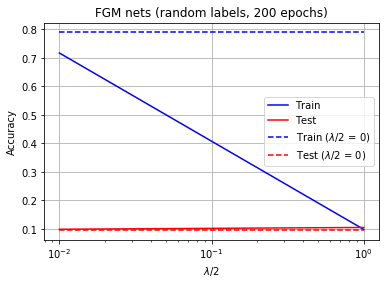

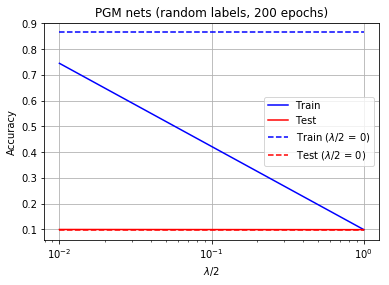

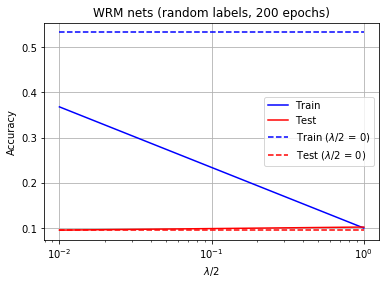

In [26]:
# Get final training and test accuracies for networks trained on random labels
for method in methods:
    train_test_accs_file = 'save_weights/mnist/%s_train_test_accs_wd_randlabels_loadepoch200.pickle'%(method)
    results = get_train_test_accs(Xtr, Ytr_rand, Xtt, Ytt_rand, model.elunet_sn, model.elunet,
                                  adv=method, load_epoch=200, train_test_accs_file=train_test_accs_file,
                                  randmode=True, wdmode=True)
    
    # Grabbing no-regularization results
    results_ = pickle.load(file(train_test_accs_file.replace('_wd', ''), 'rb'))
    results[method+'_randlabels'] = results_[method+'_randlabels']
    
    plot_train_test_accs(results, savename='Figures/mnist_train_test_accs_randlabels_loadepoch200_%s_wd'%(method),
                         logy=False, title='%s nets (random labels, 200 epochs)'%(method.upper()), wdmode=True)

In [76]:
# Estimates of final spectral norms
for method in methods:
    snorms_file = 'save_weights/mnist/%s_final_sn_wd.pickle'%(method)
    results = get_final_sn(method, model.elunet_sn, model.elunet, load_epoch=25,
                           snorms_file=snorms_file, wdmode=True)
    
    # Grabbing no-regularization results
    results_ = pickle.load(file(snorms_file.replace('_wd', ''), 'rb'))
    results[method] = results_[method]
    
    df = snorms_to_pd_table(results, wdmode=True).round(2)
    display(df) 

,layers,$\lambda$/2 = 0,$\lambda$/2 = 0.01,$\lambda$/2 = 1.0,$\lambda$/2 = 100.0,$\lambda$/2 = 10000.0,$\lambda$/2 = 1000000.0
0,conv1,4.02,1.49,0.31,0.05,0.07,0.00
1,conv2,18.13,23.29,28.79,46.24,61.14,11.19
2,conv3,11.24,10.38,12.11,15.57,21.53,14.81
3,fc,1.74,1.90,2.31,2.98,3.90,1.57


,layers,$\lambda$/2 = 0,$\lambda$/2 = 0.01,$\lambda$/2 = 1.0,$\lambda$/2 = 100.0,$\lambda$/2 = 10000.0,$\lambda$/2 = 1000000.0
0,conv1,2.95,1.61,0.23,0.04,0.01,0.00
1,conv2,28.63,29.64,28.20,40.42,59.61,108.18
2,conv3,8.91,11.07,10.07,14.12,19.84,30.76
3,fc,1.71,1.80,2.38,3.15,3.92,3.19


,layers,$\lambda$/2 = 0,$\lambda$/2 = 0.01,$\lambda$/2 = 1.0,$\lambda$/2 = 100.0,$\lambda$/2 = 10000.0,$\lambda$/2 = 1000000.0
0,conv1,4.42,1.09,0.22,0.05,0.01,0.00
1,conv2,23.40,20.77,26.58,38.29,62.49,12.35
2,conv3,9.24,7.79,9.78,13.52,19.25,8.21
3,fc,1.58,1.90,2.28,3.16,4.12,1.60


,layers,$\lambda$/2 = 0,$\lambda$/2 = 0.01,$\lambda$/2 = 1.0,$\lambda$/2 = 100.0,$\lambda$/2 = 10000.0,$\lambda$/2 = 1000000.0
0,conv1,2.11,0.66,0.19,0.03,0.00,0.00
1,conv2,11.20,12.41,21.37,26.27,35.67,10.11
2,conv3,4.69,5.13,7.28,11.91,17.97,10.46
3,fc,1.41,1.34,1.91,2.33,2.83,1.62


INFO:tensorflow:Restoring parameters from save_weights/mnist/erm_wd0.01/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights/mnist/erm_wd1.0/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights/mnist/erm_wd100.0/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights/mnist/erm_wd10000.0/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights/mnist/erm_wd1000000.0/checkpoints/epoch25


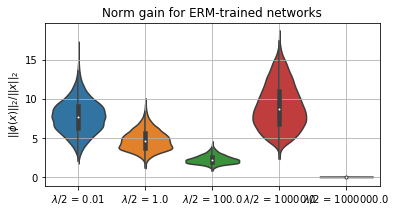

INFO:tensorflow:Restoring parameters from save_weights/mnist/fgm_wd0.01/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights/mnist/fgm_wd1.0/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights/mnist/fgm_wd100.0/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights/mnist/fgm_wd10000.0/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights/mnist/fgm_wd1000000.0/checkpoints/epoch25


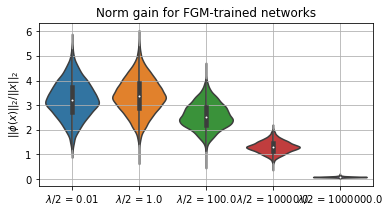

INFO:tensorflow:Restoring parameters from save_weights/mnist/pgm_wd0.01/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights/mnist/pgm_wd1.0/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights/mnist/pgm_wd100.0/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights/mnist/pgm_wd10000.0/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights/mnist/pgm_wd1000000.0/checkpoints/epoch25


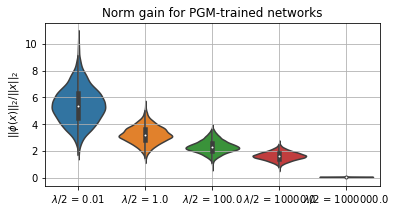

INFO:tensorflow:Restoring parameters from save_weights/mnist/wrm_wd0.01/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights/mnist/wrm_wd1.0/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights/mnist/wrm_wd100.0/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights/mnist/wrm_wd10000.0/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights/mnist/wrm_wd1000000.0/checkpoints/epoch25


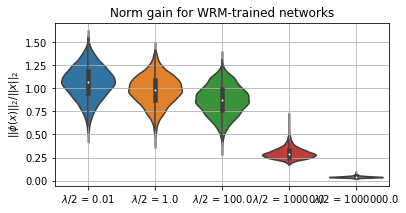

In [29]:
# Norm ratio of output layer to input
for method in methods:
    fcnorms_file = 'save_weights/mnist/%s_output_norms_wd.pickle'%(method)
    norm_input = np.array([np.sqrt(np.sum(np.square(i))) for i in Xtt])
    results = get_output_norms(Xtt, method, model.elunet_sn, model.elunet, load_epoch=25,
                               fcnorms_file=fcnorms_file, wdmode=True)
    violin_plots_of_norm_output_to_input_ratios(results, norm_input, wdmode=True,
                                                title='Norm gain for %s networks'%(method.upper()),
                                                savename='Figures/mnist_violin_%s_wd'%(method))

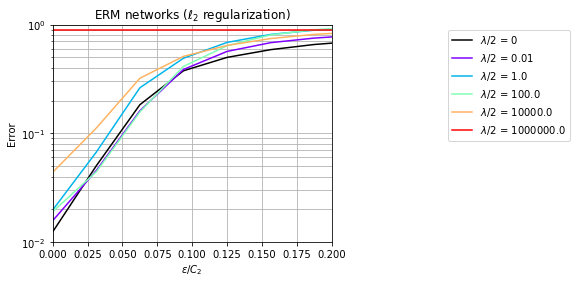

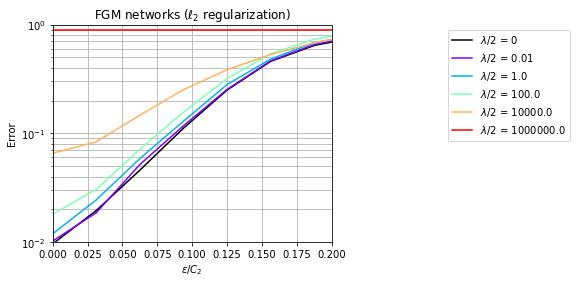

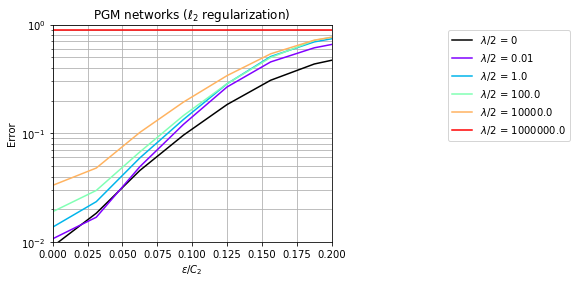

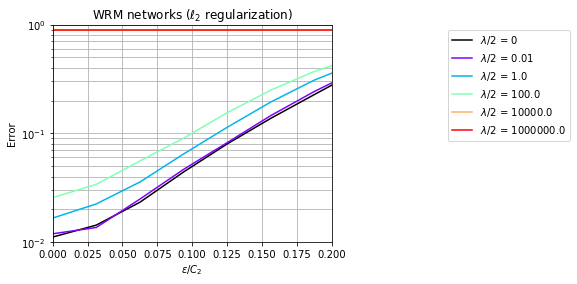

In [17]:
curves_file = 'save_weights/mnist/wd_adv_sweep_curves.pickle'

# Grabbing no-regularization results
all_wd_curves_ = pickle.load(file(curves_file.replace('wd', 'beta'), 'rb'))

if os.path.isfile(curves_file):
    all_wd_curves = pickle.load(file(curves_file, 'rb'))
else:
    all_wd_curves = {}
    
for method in methods:
    if method not in all_wd_curves:
        all_wd_curves[method] = param_sweep_curves(Xtt, Ytt, method, eps_list, model.elunet_sn,
                                                   model.elunet, load_epoch=25, wdmode=True)
        
    all_wd_curves[method][method] = all_wd_curves_[method][method]
    
    plot_acc_curves(all_wd_curves[method], eps_list/C2, report_test=False, wdmode=True,
                    title=u'%s networks ($\ell_2$ regularization)'%(method.upper()),
                    sort_func=sort_func,
                    savename='Figures/mnist_adv_curves_%s_wd'%(method))
    
pickle.dump(all_wd_curves, file(curves_file, 'wb'))

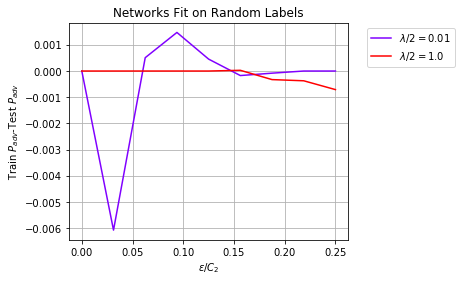

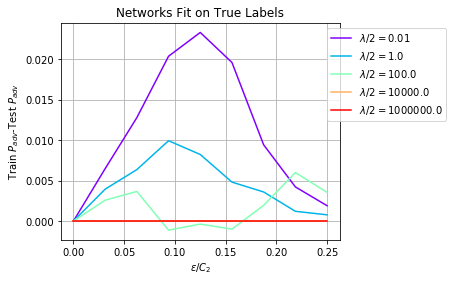

In [58]:
adv = 'wrm'
curves_file = 'save_weights/mnist/%s_perturbation_curves_wd.pickle'%(adv)
adv_results = get_perturbation_curves(Xtr, Xtt, model.elunet_sn, model.elunet, adv,
                                      eps_list, load_epoch=25, curves_file=curves_file, 
                                      maindir='save_weights/mnist/', verbose=False, wdmode=True)

plot_perturbation_curves(eps_list/C2, adv_results, ylim=None, wdmode=True,
                         savename='Figures/mnist_perturbation_curves_%s_wd'%(adv))

                 wrm with eps/C2 = 0.0558342060
          wrm_wd0.01 with eps/C2 = 0.0600389320
           wrm_wd1.0 with eps/C2 = 0.0796296895
         wrm_wd100.0 with eps/C2 = 0.0903111855
       wrm_wd10000.0 with eps/C2 = 0.0001769523
     wrm_wd1000000.0 with eps/C2 = 0.0000001096


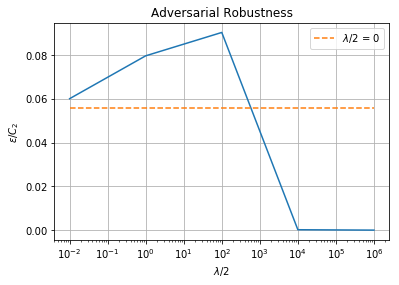

In [67]:
# Look at WRM robustness as a function of beta
eps_file = 'save_weights/mnist/wrm_eps_train_wd.pickle'
results = get_eps_wrm(Xtr, model.elunet_sn, model.elunet, eps_wrm, load_epoch=25,
                      eps_file=eps_file, wdmode=True)

# Get results from no-regularization case
results_ = pickle.load(file('save_weights/mnist/wrm_eps_train.pickle', 'rb'))
results['wrm'] = results_['wrm']

for k, v in sorted(results.items()):
    print('%20s with eps/C2 = %.10f'%(k, v/C2))
    
plot_wrm_robustness(results, C2=C2, savename='Figures/mnist_adv_robustness_with_WD', wdmode=True)

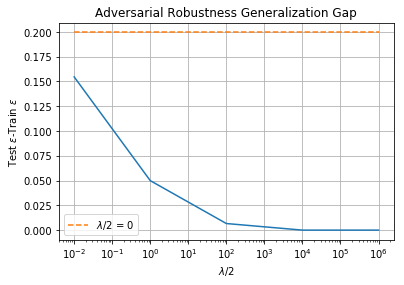

In [70]:
# Look at difference in robustness as a function of beta
eps_file = 'save_weights/mnist/wrm_eps_test_wd.pickle'
results_tt = get_eps_wrm(Xtt, model.elunet_sn, model.elunet, eps_wrm, load_epoch=25,
                         eps_file=eps_file, wdmode=True)
results_diff = {k:results_tt[k]-results[k] for k in results if k != 'wrm'}

# Get results from no-regularization case
results_tt_ = pickle.load(file('save_weights/mnist/wrm_eps_test.pickle', 'rb'))
results_diff['wrm'] = results_tt_['wrm']-results_['wrm']

plot_wrm_robustness(results_diff, C2=None, ylabel=u'Test $\epsilon$-Train $\epsilon$', wdmode=True,
                    title='WRM adversarial robustness generalization gap',
                    savename='Figures/mnist_adv_robustness_generalization_with_WD')